<a href="https://colab.research.google.com/github/saspav/titanic/blob/master/homework_module_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Титаник

https://stepik.org/lesson/393048/step/1?unit=382065

В этом домашнем задании вам предлагается решить задачу предсказания выживших пассажиров Титаника. Эту задачу машинного обучения рано или поздно решает, наверное, любой, кто обучается анализу данных. Информация о датасете доступна по <a href=https://www.kaggle.com/c/titanic>ссылке</a>.

Кстати, здесь же есть много готовых решений нашей задачи. Решение можно посмотреть в разделе <a href=https://www.kaggle.com/c/titanic/code>code на kaggle</a>.

Некоторые решения, которые уже есть:
https://www.kaggle.com/hacktech33/titanic-solution-xgboost (простое решение)

https://www.kaggle.com/shrutijhaa/in-top-3-titanic-machine-learning-from-disaster (возможно, слишком много визуализации, но хорошее качество)

https://www.kaggle.com/blackhurt/top-3-using-voting-classifier (сильное решение, использует метод простого голосования трёх сильных моделей)

In [40]:
!pip install scikit_learn==1.3.2 -q
!pip install catboost==1.2.7 -q
!pip install featuretools==1.31.0 -q
!pip install optuna==4.1.0 -q
!pip install optuna-integration==4.1.0 -q

# Загруза датасета
!wget -q https://raw.githubusercontent.com/saspav/titanic/refs/heads/master/data/test.csv
!wget -q https://raw.githubusercontent.com/saspav/titanic/refs/heads/master/data/train.csv
!wget -q https://raw.githubusercontent.com/saspav/titanic/refs/heads/master/data/titanic_data.csv
!wget -q https://raw.githubusercontent.com/saspav/titanic/refs/heads/master/data/titanic_surv.csv

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from IPython.display import display # импортируем метод display для вывода таблиц

plt.rcParams["figure.figsize"] = (16, 6)
# Установим опции, которые помогут привести таблицу к желаемому виду
pd.set_option('display.max_columns', None) # реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) # реализуем возможность вывода значений float до 3 знаков после запятой

warnings.filterwarnings("ignore")

%matplotlib inline

In [42]:
np.__version__, pd.__version__, sns.__version__

('1.26.4', '2.2.2', '0.13.2')

## Загрузка данных

Загрузим датасет Titanic из приложенных файлов. В первом файле находится информация о пассажирах, во втором -- информация о том, выжил пассажир или нет.

Если вы запускаете ноутбук на Google Colab, самым простым способом загрузить данные в ноутбук будет примонтировать к Colab ваш Google Drive. Для этого сначала положите в свою корневую директорию Google Drive  файлы, приложенные к этому ноутбуку, а затем выполните три закоментированные строчки в клетке ниже. <a href=https://www.machinelearningmastery.ru/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166/>Подробная инструкция по работе с Google Drive + Google Colab</a>

In [43]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#data = pd.read_csv('/content/gdrive/My Drive/titanic_data.csv, index_col='PassengerId')

#Если запускаете ноутбук локально:
data = pd.read_csv('titanic_data.csv', index_col='PassengerId')

In [44]:
basic_features = data.columns

y = pd.read_csv('titanic_surv.csv')
y.index = data.index

print(f'Всего {len(data)} пассажиров в выборке')
data.head()

Всего 891 пассажиров в выборке


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
5,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [45]:
y.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [46]:
data = data.join(y)
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0


## Исследование датасета

### Задание 1 (1 балл)
Опишите датасет. Сколько в нём мужчин, сколько женщин? Посчитайте распределение по классам пассажиров. Используйте функцию ``pd.Series.value_counts``. <a href=https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html>Пример использования</a>

Посчитайте долю выживших мужчин к общему количеству мужчин, а также женщин к общему количеству женщин. Сделайте выводы.
Проведите схожую аналитику по возрасту выживших и по классу выживших.

Вам поможет функция ``plt.hist()``. <a href=https://matplotlib.org/3.3.1/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py> Пример использования </a>

In [47]:
data.Sex.value_counts()
# 577 мужчин, 314 женщины

,count
Sex,
male,577
female,314


In [48]:
# Общее количество мужчин и женщин
total_men = data[data['Sex'] == 'male'].shape[0]
total_women = data[data['Sex'] == 'female'].shape[0]
# Количество выживших мужчин и женщин
survived_men = data[(data['Sex'] == 'male') & (data['Survived'] == 1)].shape[0]
survived_women = data[(data['Sex'] == 'female') & (data['Survived'] == 1)].shape[0]
# Доля выживших
survived_men_ratio = survived_men / total_men if total_men > 0 else 0
survived_women_ratio = survived_women / total_women if total_women > 0 else 0
print(f"Доля выживших мужчин: {survived_men_ratio:.2%}")
print(f"Доля выживших женщин: {survived_women_ratio:.2%}")

Доля выживших мужчин: 18.89%
Доля выживших женщин: 74.20%


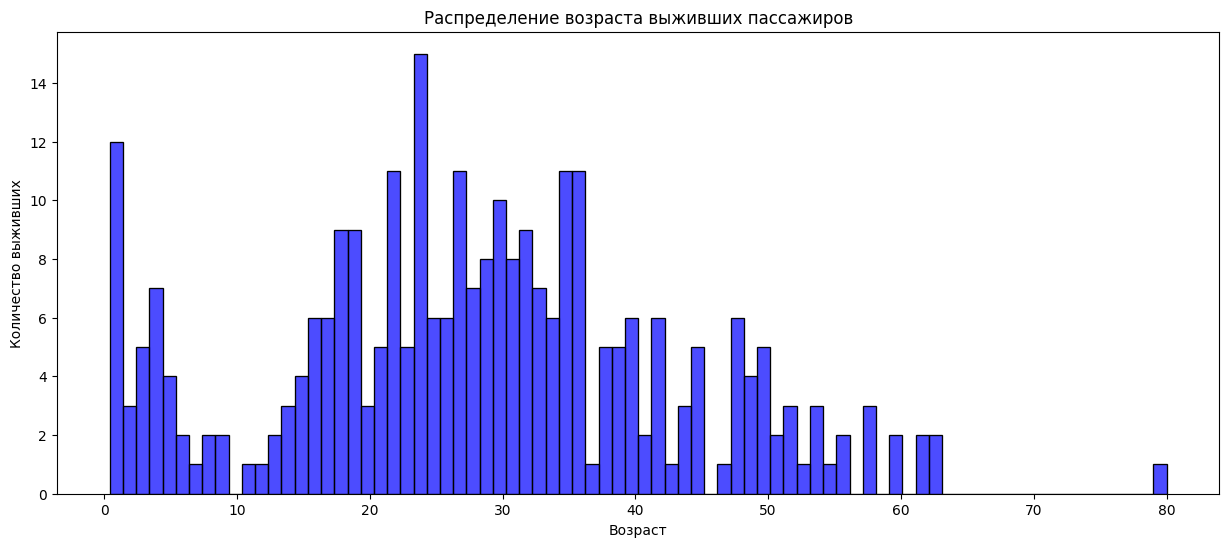

In [49]:
# Фильтрация по выжившим
survived_people = data[data['Survived'] == 1]

# Построение гистограммы возраста выживших
fig, ax = plt.subplots(figsize=(15, 6))
sns.histplot(survived_people['Age'].dropna(), bins=80, alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение возраста выживших пассажиров')
plt.xlabel('Возраст')
plt.ylabel('Количество выживших')
plt.show()

Pclass
1   0.630
2   0.473
3   0.242
Name: Survival_Rate, dtype: float64


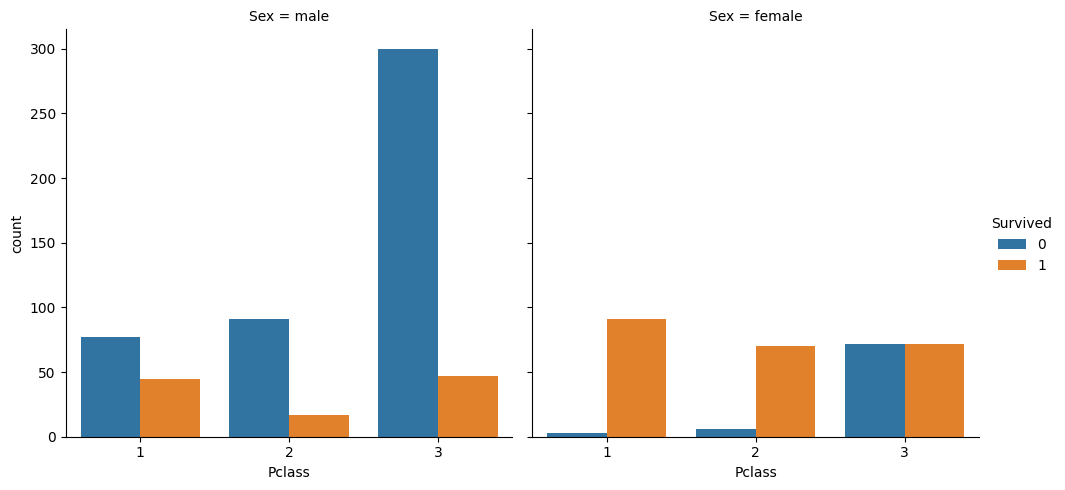

In [50]:
# Группировка по классу и подсчет выживших
survival_by_class = data.groupby(['Pclass', 'Survived']).size().unstack()
survival_by_class['Survival_Rate'] = survival_by_class[1] / (survival_by_class[0] + survival_by_class[1])

# Печать долей выживших по классам
print(survival_by_class['Survival_Rate'])

sns.catplot(x="Pclass", hue="Survived", col="Sex", data=data, kind="count")
plt.show()

#### Выводы:
Видим, что женщин выжило больше, чем мужчин (хотя на Титанике мужчин было почти в 2 раза больше, чем женщин). Чем выше класс каюты - тем больше % выживших. Это соотношение выживших женщин сохраняется по классу кают, вот мужчин больше спаслось в первом и втором классе. По возрасту: спасали младенцев и дошколят, молодых людей 22-25 лет, людей среднего возраста около 35.

## Заполнение пропусков в данных
В данных имеются пропуски в трёх колонках:

In [51]:
data.columns[data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

Для простоты заполним все пропуски в категориальных колонках новым классом "0", а в числовой колонке Age --- медианным значением.

In [52]:
data.loc[:, ['Cabin', 'Embarked']] = data.loc[:, ['Cabin', 'Embarked']].fillna('0')
data['Age'] = data['Age'].fillna(data['Age'].median())

## Подготовка плана тестирования

### Задание 2. (0 баллов)
Разделите выборку на обучающее и тестовое множество в соотношении 70:30.

In [53]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.3, random_state=127)

## Выделение новых признаков
Теперь отложим тестовые данные и приступим к моделированию. Внимательно изучите данные. Можете ли вы выделить признаки, которые не указаны явно в таблице?

### Задание 3 (1 балл)
 Сформируйте по крайней мере один новый признак и объясните ваш выбор. Пример признака сформирован за вас.

Указания:
- Пассажиров можно поделить на несколько классов по их именам.
- Различных номеров кают слишком много. Но буквы в номерах кают указывают на их местоположение. (***Этот признак сформирован в примере***)
- Возможно, имеет смысл отделить мальчиков от мужчин. Отделять девочек от женщин может быть не так важно
- Другие идеи для признаков можно почерпнуть на форуме в обсуждении задачи на kaggle.com.

In [54]:
data.head(7)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,0,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,0,S,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,0,S,0
6,3,"Moran, Mr. James",male,28.000,0,0,330877,8.458,0,Q,0
7,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.862,E46,S,0


In [55]:
data['Cabin']

,Cabin
PassengerId,
1,0
2,C85
3,0
4,C123
5,0
...,...
887,0
888,B42
889,0


In [56]:
def get_cabin_letter(df):
    df['cabin_type'] = df.Cabin.map(lambda z: z[0])
    return df


data = get_cabin_letter(data)

Выделим титул из имени пассажира и длину его имени.

In [57]:
import re


def find_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    return title_search.group(1).lower() if title_search else ''


def get_title(df):
    # выделение титула
    df['title'] = df.Name.apply(find_title)
    # подсчет длины имени
    df['len_name'] = df.Name.str.len()
    return df


data = get_title(data)

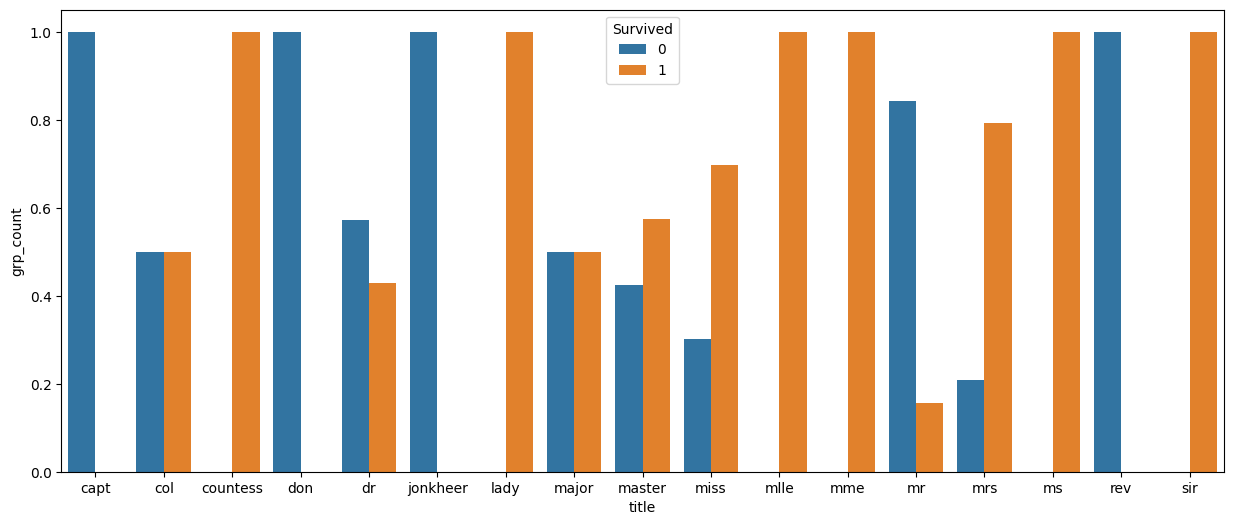

In [58]:
def normalize_count(row):
    return row['grp_count'] / max_grp[row['title']]


grp = data.groupby(['title', 'Survived'], as_index=False).Name.count()
grp.columns = ['title', 'Survived', 'grp_count']
g = grp.groupby('title', as_index=False).grp_count.sum()
max_grp = {g.loc[ind, 'title']: g.loc[ind, 'grp_count'] for ind in g.index}
# нормализация количества пассажиров по группам
grp.grp_count = grp.apply(normalize_count, axis=1)
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x="title", y='grp_count', hue="Survived", data=grp)
plt.show()

Видим, что пассажиры с одними титулами выжило больше, чем с другими.

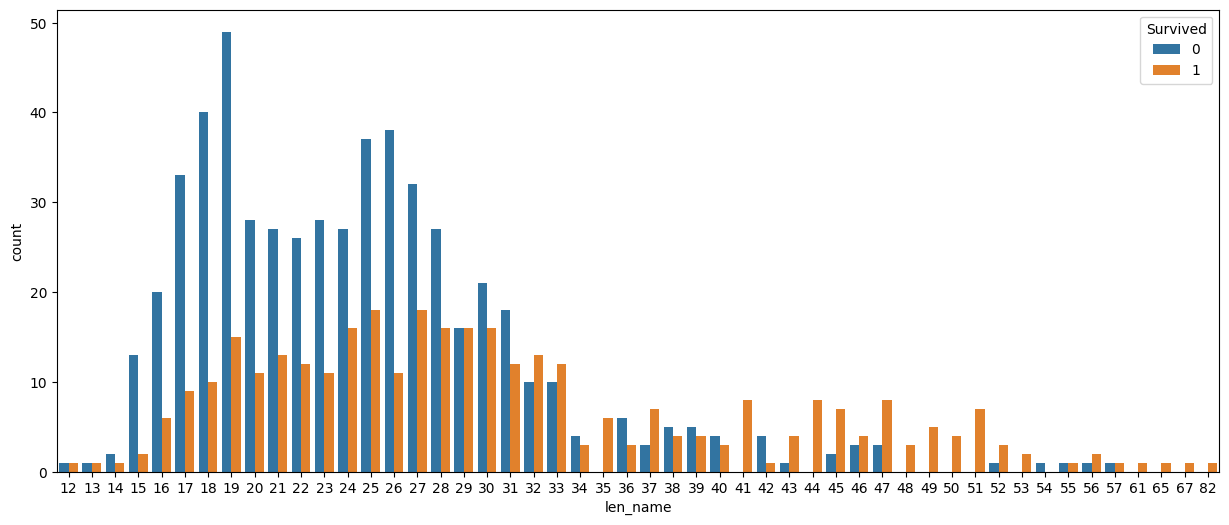

In [59]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x="len_name", hue="Survived", data=data)
plt.show()

Видим, что после определенной длины имени пассажиров больше выжило, чем погибло.  Т.е. богатые и титулованные особы, во времена Титаника чего только не добавляли в свои фамилии, так что если исходить из того что чем длиннее фамилия, тем богаче человек, то бросить все силы на спасение первого класса, выглядит вполне логичным.

## Кодирование категориальных признаков и обработка данных
Все признаки сейчас делятся на числовые, бинарные, категориальные и текстовые. К текстовым признакам можно отнести имя пассажира, номер билета и номер каюты: значения этих признаков уникальны почти для всех пассажиров, и простого способа использовать их в модели не существует.

### Задание 4 (0 баллов)
Пока используя только изначальные признаки, перекодируйте категориальные признаки функцией ``pd.get_dummies``. Естественно, имена пассажиров и номера билетов и кают кодировать не стоит, поскольку все значения этих признаков уникальные.

In [60]:
data.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Survived', 'cabin_type', 'title', 'len_name'],
      dtype='object')

## Обучение baseline-модели

### Задание 5 (1 балл)

Обучите одну из простых известных вам моделей. Измерьте качество полученной модели на кросс-валидации (используйте только обучающую выборку!)

In [61]:
# Список признаков, которые нужно перекодировать
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'cabin_type', 'title']

# Применение pd.get_dummies для категориальных признаков
train = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Проверка результатов
train.head()

,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Survived,len_name,Pclass_2,Pclass_3,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cabin_type_A,cabin_type_B,cabin_type_C,cabin_type_D,cabin_type_E,cabin_type_F,cabin_type_G,cabin_type_T,title_col,title_countess,title_don,title_dr,title_jonkheer,title_lady,title_major,title_master,title_miss,title_mlle,title_mme,title_mr,title_mrs,title_ms,title_rev,title_sir
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",22.000,1,0,A/5 21171,7.250,0,0,23,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000,1,0,PC 17599,71.283,C85,1,51,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,"Heikkinen, Miss. Laina",26.000,0,0,STON/O2. 3101282,7.925,0,1,22,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000,1,0,113803,53.100,C123,1,44,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
5,"Allen, Mr. William Henry",35.000,0,0,373450,8.050,0,0,24,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [62]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


def fit_model(model, train):
    # Отделим целевую переменную и признаки
    X = train.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])
    y = train['Survived']

    # Разделение на обучающую и тестовую выборки (70% на обучение, 30% на тест)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=127, stratify=y)

    # Стандартизация признаков (это особенно важно для логистической регрессии)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Оценка качества модели с помощью кросс-валидации
    cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5)

    # Вывод результатов
    print(f"Кросс-валидация {model.__class__.__name__}: {cv_score.round(3)}")
    print(f"Средняя точность на кросс-валидации: {cv_score.mean():.3f} ± {cv_score.std():.3f}")
    return model


log_reg = LogisticRegression(solver='sag', max_iter=1000, random_state=127)
log_reg = fit_model(log_reg, train)

svc = SVC(random_state=127)
svc = fit_model(svc, train)

clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=127)
clf_tree = fit_model(clf_tree, train)

Кросс-валидация LogisticRegression: [0.808 0.832 0.848 0.766 0.839]
Средняя точность на кросс-валидации: 0.819 ± 0.029
Кросс-валидация SVC: [0.76  0.84  0.896 0.79  0.855]
Средняя точность на кросс-валидации: 0.828 ± 0.048
Кросс-валидация DecisionTreeClassifier: [0.736 0.784 0.752 0.734 0.71 ]
Средняя точность на кросс-валидации: 0.743 ± 0.025


### Задание 6 (1 балл)
Добавьте в модель два новых сгенерированных признака. Если нужно, добавьте признаки, сгенерированные ohe-hot кодированием. Обучите ту же самую модель на расширенном множестве признаков. Улучшилось ли качество предсказания на кросс-валидации?

Посмотрим на распределение между признаками SibSp - Количество Братьев (Сестер) / Супругов на борту и Parch - Количество Родителей / Детей на борту.

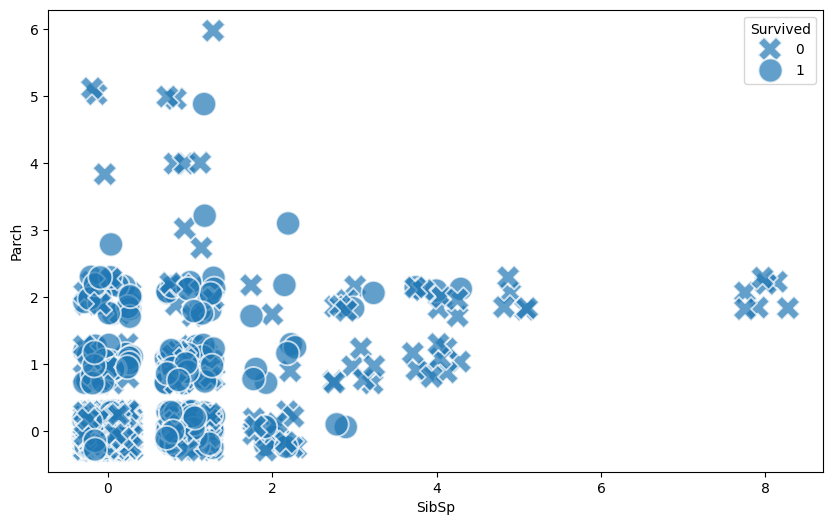

In [63]:
import numpy as np

# Создаем копию данных, чтобы не изменять оригинал
train_jittered = train.copy()

# Добавляем случайный шум к данным
np.random.seed(42)  # Для воспроизводимости
train_jittered["SibSp"] += np.random.uniform(-0.3, 0.3, size=len(train))
train_jittered["Parch"] += np.random.uniform(-0.3, 0.3, size=len(train))

fig, ax = plt.subplots(figsize=(10, 6))
markers = {0: 'X', 1: 'o'}
sns.scatterplot(
    x="SibSp",
    y='Parch',
    style="Survived",
    data=train_jittered,
    alpha=0.7,
    markers=markers,
    s=300
)
plt.show()

Похоже, что на выживаемость влияет как отсутствие родственников, так и большое их количество: выжившие имели по 1-3 родственнику на борту. Добавим признаки "alone" и "family" и посмотрим на графики.

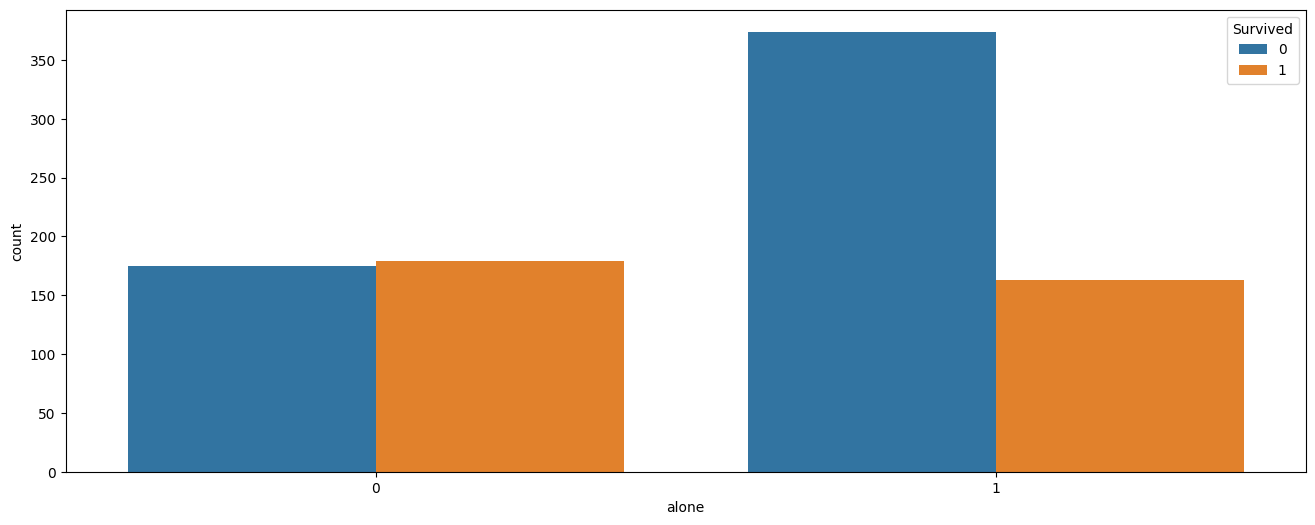

In [64]:
def family_category(x):
    # категория семьи: 1-одиночка, 2-маленькая, 3-средняя, 4-большая
    if x == 1:
        return 1
    elif 1 < x < 5:
        return 2
    elif 4 < x < 8:
        return 3
    else:
        return 4


def fare_category(x):
    # категории по цене билета
    if x < 6.35:
        return 1
    elif 6.35 < x < 8.75:
        return 2
    elif 8.75 < x < 21.25:
        return 3
    elif 21.25 < x < 30.55:
        return 4
    elif 30.55 < x < 35.25:
        return 5
    else:
        return 6


def age_category(x):
    # возрастные категории
    if x < 15.8:
        return 1
    elif 15.8 < x < 24.2:
        return 2
    elif 24.2 < x < 30.8:
        return 3
    elif 30.8 < x < 36.2:
        return 4
    elif 36.2 < x < 45.2:
        return 5
    elif 45.2 < x < 63.8:
        return 6
    return 7


def add_features(df):
    df['alone'] = df.apply(lambda x: 1 if x['SibSp']+x['Parch'] == 0 else 0, axis=1)
    df['family'] = df.apply(lambda x: x['SibSp']+x['Parch']+1, axis=1)
    # разбивка возрастов по категориям
    df['idx_age'] = df.Age.apply(age_category)
    # отдельно выделим пенсионеров
    df['retirer'] = df.Age.map(lambda x: 1 if x > 63.8 else 0)
    # разбивка семей по категориям
    df['idx_family'] = df.family.apply(family_category)
    df['is_cabin'] = df.Cabin.apply(lambda x: 1 if x != '0' else 0)
    return df


train = add_features(train)

sns.countplot(x="alone", hue="Survived", data=train)
plt.show()

Видим, что % выживаемости у пассажиров с родственниками выше в 2 раза, чем у одиноких пассажиров. Подтверждение этой гипотезы видно на следующем графике.

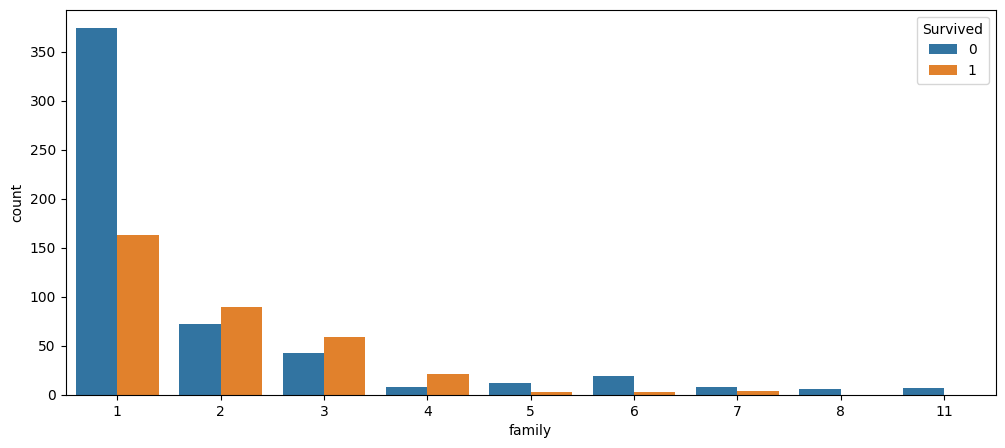

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(x="family", hue="Survived", data=train)
plt.show()

Посмотрим на выживаемость в зависимости от наличия номера каюты в целом по всем пассажирам и в разрезе по полу.

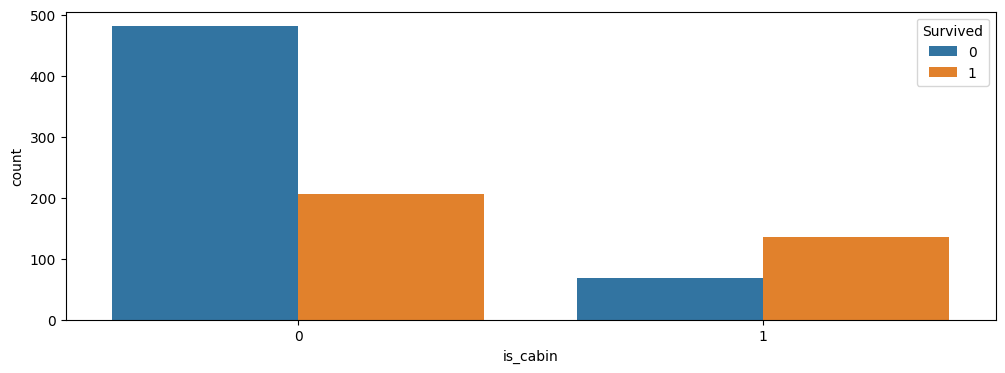

In [66]:
train['is_cabin'] = train.Cabin.apply(lambda x: 1 if x != '0' else 0)
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(x="is_cabin", hue="Survived", data=train)
plt.show()

У пассажиров с номером каюты % выживаемости выше,  а у женщин с номером каюты эта разница многократна.

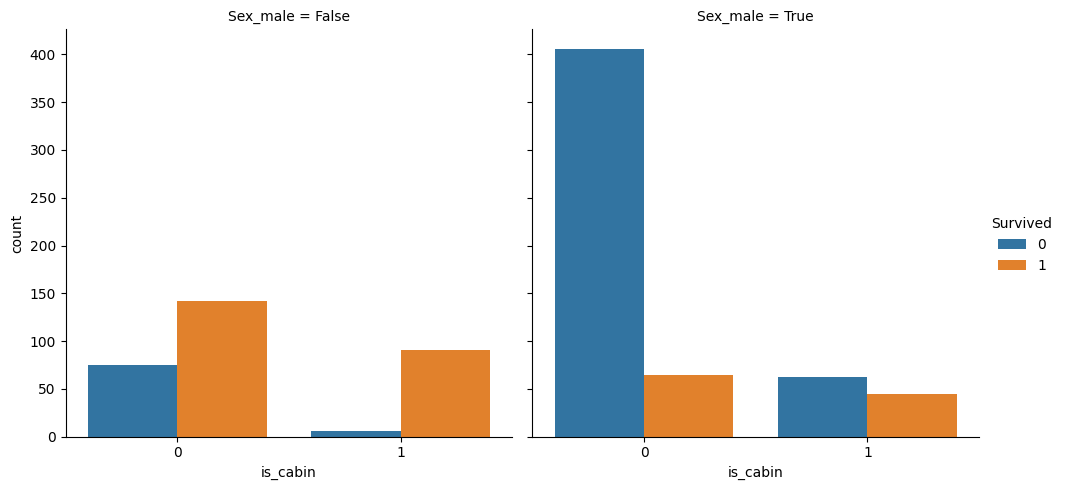

In [67]:
sns.catplot(x="is_cabin", hue="Survived", col="Sex_male", data=train, kind="count")
plt.show()

In [68]:
# Обучите ту же самую модель на расширенном множестве признаков.
# Улучшилось ли качество предсказания на кросс-валидации?

log_reg = LogisticRegression(solver='sag', max_iter=1000, random_state=127)
log_reg = fit_model(log_reg, train)

svc = SVC(random_state=127)
svc = fit_model(svc, train)

clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=127)
clf_tree = fit_model(clf_tree, train)

Кросс-валидация LogisticRegression: [0.776 0.848 0.832 0.782 0.847]
Средняя точность на кросс-валидации: 0.817 ± 0.031
Кросс-валидация SVC: [0.768 0.816 0.872 0.774 0.863]
Средняя точность на кросс-валидации: 0.819 ± 0.043
Кросс-валидация DecisionTreeClassifier: [0.752 0.76  0.768 0.718 0.734]
Средняя точность на кросс-валидации: 0.746 ± 0.018


- Улучшилось ли качество предсказания на кросс-валидации?

Для линейной модели качество на кросс-валидации не изменилось, т.к. линейная модель не в состоянии уловить нелинейные зависимости, а вот для деревьев решений качество чуть улучшилось.

## Дополнительное моделирование
### Задание 7 (2 балла)
Теперь более серьёзно подойдём к моделированию. Попробуйте несколько алгоритмов из тех, что мы проходили в курсе. Вам помогут ноутбуки с линейными алгоритмами и выбором модели. Хотя бы для одного алгоритма проведите подбор оптимального гиперпараметра.

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(verbose=0, random_state=127)
forest = fit_model(forest, train)

Кросс-валидация RandomForestClassifier: [0.76  0.784 0.888 0.831 0.847]
Средняя точность на кросс-валидации: 0.822 ± 0.045


## Результаты моделирования

### Задание 8 (1 балл)
Измерьте качество итоговой модели на кросс-валидации. Выполните предсказание на тестовом множестве и сохраните их в переменную ``y_test``. Измерьте итоговое качество на тестовом множестве.

In [70]:
from catboost import CatBoostClassifier

cat_clf = CatBoostClassifier(verbose=0, random_state=127)
cat_clf = fit_model(cat_clf, train)

Кросс-валидация CatBoostClassifier: [0.744 0.856 0.888 0.831 0.815]
Средняя точность на кросс-валидации: 0.827 ± 0.048


### Будем подбирать гиперпараметры "по-взрослому" с помощью optuna

In [71]:
import optuna
from optuna.integration import CatBoostPruningCallback
from catboost import CatBoostClassifier, Pool


def objective(trial: optuna.Trial) -> float:
    params = {
        "depth": trial.suggest_int("depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 30),
        "border_count": trial.suggest_int("border_count", 64, 384),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 3, 9),
        "rsm": trial.suggest_float("rsm", 0.5, 1.0),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type",
                                                    ["Bayesian", "Bernoulli", "MVS"]),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method",
                                                            ["Newton", "Gradient"]),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 20.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    loss_function = "Logloss"
    eval_metric = "Accuracy"

    clf = CatBoostClassifier(
        loss_function=loss_function,
        eval_metric=eval_metric,
        cat_features=column_dummies,
        random_seed=127,
        # task_type="GPU",
        **params
    )

    pruning_callback = CatBoostPruningCallback(trial, eval_metric)

    clf.fit(pool_train, eval_set=pool_valid,
            verbose=0,
            early_stopping_rounds=50,
            callbacks=[pruning_callback],
            )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    return clf.best_score_['validation'][eval_metric]


def change_title(row):
    if row['Sex'] == 'female':
        if row['title_cat'] in ['mme', 'countess', 'lady', 'dona', 'dr']:
            return 'mrs'
        elif row['title_cat'] in ['mlle', 'ms']:
            return 'miss'
        else:
            return row['title_cat']
    else:
        if row['title_cat'] in ['capt', 'col', 'don', 'dr', 'major',
                                'rev', 'sir', 'jonkheer']:
            return 'other'
        else:
            return row['title_cat']


def make_features(df):
    # собрал обработку признаков в одном месте
    df['Age'].fillna(df['Age'].median(), inplace = True)
    df['Fare'].fillna(df['Fare'].median(), inplace = True)
    df['Embarked'].fillna(df['Embarked'].value_counts().index[0], inplace = True)
    df['Cabin'] = df.Cabin.fillna("U").apply(lambda x: x[0])
    df['Cabin'] = df.Cabin.apply(lambda x: "A" if x == "T" else x)
    df = get_title(df)
    df = add_features(df)
    df = get_cabin_letter(df)
    df['idx_fare'] = df.Fare.apply(fare_category)
    # более крупная группировка по титулам
    df['title_cat'] = df.title
    df['title_cat'] = df.apply(change_title, axis=1)
    return df


column_dummies = ['Pclass',
                  'Sex',
                  'Embarked',
                  'cabin_type',
                  'title',
                  'title_cat',
                  'idx_family',
                  'idx_fare',
                  'idx_age',
                  ]

# Описание полей датасета:
# PassengerId - ID пассажира
# Survived - Пасажир выжил (1 = Да; 0 = Нет)
# Pclass - Класс каюты пассажира (1 = Первый; 2 = Второй; 3 = Третий)
# Name - фамилия, титул, имя
# Sex - Пол
# Age - Возраст
# SibSp - Количество Братьев (Сестер) / Супругов на борту
# Parch - Количество Родителей / Детей на борту
# Ticket - номер билета
# Fare - Пассажирский тариф
# Cabin - каюта
# Embarked - Порт посадки (C = Cherbourg; Q = Queenstown; S = Southampton)
#
# # добавленные поля:
# title - титул
# len_name - длина имени
# alone - Пассажир путешествовал один (True = Да; False = Нет)
# family - количество всех членов семьи
# is_cabin - есть каюта (есть; нет) - для визуализации
# title_cat - более крупная группировка по титулам
# cabin - есть каюта (1 = Да; 0 = Нет)

In [72]:
train_df = pd.read_csv('train.csv', index_col='PassengerId')
test_df = pd.read_csv('test.csv', index_col='PassengerId')


train_df = make_features(train_df)
test_df = make_features(test_df)

features2drop = ['Name', 'Ticket', 'Cabin',]

model_columns = test_df.columns.tolist()

train = train_df[model_columns].drop(columns=features2drop, errors='ignore')
target = train_df['Survived']
test_df = test_df[model_columns].drop(columns=features2drop, errors='ignore')

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target,
                                                      test_size=0.3,
                                                      stratify=y,
                                                      random_state=127)

print('X_train.shape', X_train.shape, 'пропусков:', X_train.isna().sum().sum())
print('X_valid.shape', X_valid.shape, 'пропусков:', X_valid.isna().sum().sum())

pool_train = Pool(data=X_train, label=y_train, cat_features=column_dummies)
pool_valid = Pool(data=X_valid, label=y_valid, cat_features=column_dummies)

X_train.shape (623, 18) пропусков: 0
X_valid.shape (268, 18) пропусков: 0


In [74]:
# Установить уровень логирования Optuna на WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

loss_function = "Logloss"
eval_metric = "Accuracy"

clf_params = dict(cat_features=column_dummies,
                  loss_function=loss_function,
                  eval_metric=eval_metric,
                  early_stopping_rounds=100,
                  random_seed=127,
                  )

# Выполнить оптимизацию гиперпараметров
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=127)
)
study.optimize(objective,
               n_trials=200,
               timeout=600,
               show_progress_bar=True,
               )

print("Количество завершенных испытаний: {}".format(len(study.trials)))
print("Лучшее испытание:")
trial = study.best_trial
print("  Значение: {}".format(trial.value))
print("\nbest_params =", trial.params)

clf_params.update(trial.params)

  0%|          | 0/200 [00:00<?, ?it/s]

Количество завершенных испытаний: 200
Лучшее испытание:
  Значение: 0.8619402985074627

best_params = {'depth': 5, 'learning_rate': 0.23504834638926267, 'l2_leaf_reg': 5.699236806334827, 'border_count': 309, 'random_strength': 6.781290266094989, 'one_hot_max_size': 8, 'rsm': 0.923685364342143, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'leaf_estimation_method': 'Newton', 'subsample': 0.38648121232986127}


In [75]:
from catboost import cv



clf = CatBoostClassifier(verbose=0, **clf_params)


cv_data = cv(
    params=clf_params,
    pool=Pool(train, label=target, cat_features=column_dummies),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=127,
    plot=True, # Никуда без визуализатора
    stratified=True,
    verbose=False,
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8212290503
bestIteration = 0

Training on fold [1/5]

bestTest = 0.8659217877
bestIteration = 63

Training on fold [2/5]

bestTest = 0.8595505618
bestIteration = 51

Training on fold [3/5]

bestTest = 0.8820224719
bestIteration = 20

Training on fold [4/5]

bestTest = 0.8361581921
bestIteration = 69



In [76]:
# Извлечение информации о лучших итерациях для каждого фолда
train_scores = cv_data['train-Accuracy-mean'].mean()
train_std = cv_data['train-Accuracy-std'].mean()
test_scores = cv_data['test-Accuracy-mean']
test_std = cv_data['test-Accuracy-std']

# Вывод результатов
print(f"Средняя точность при обучении : {train_scores.mean():.3f} ± {train_std.std():.3f}")
print(f"Средняя точность при валидации: {test_scores.mean():.3f} ± {test_std.std():.3f}")

Средняя точность при обучении : 0.908 ± 0.000
Средняя точность при валидации: 0.829 ± 0.006


In [77]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# Измерьте качество итоговой модели на кросс-валидации.
# Выполните предсказание на тестовом множестве и сохраните их в переменную y_test.
# Измерьте итоговое качество на тестовом множестве.

clf.fit(pool_train, eval_set=pool_valid, verbose=0, early_stopping_rounds=50,)

y_test = clf.predict(X_valid)

print(f"Точность на отложенной выборке: {accuracy_score(y_valid, y_test):.3f}")

Точность на отложенной выборке: 0.862


## Выводы
### Задание 9 (3 балла)
Сделайте выводы. Какие из идей сработали? Какие оказались лишними?

Средняя точность на кросс-валидации для исходных данных:

- LogisticRegression: 0.819 ± 0.029
- SVC: 0.828 ± 0.048
- DecisionTreeClassifier: 0.743 ± 0.025

После добавления двух признаков, Средняя точность на кросс-валидации:

- LogisticRegression: 0.817 ± 0.031
- SVC: 0.819 ± 0.043
- DecisionTreeClassifier: 0.746 ± 0.018
- RandomForestClassifier: 0.822 ± 0.045
- CatBoostClassifier: 0.827 ± 0.048

После добавления еще признаков и подбора гиперпараметров для CatBoostClassifier:

Средняя точность при обучении : 0.908 ± 0.000
Средняя точность при валидации: 0.829 ± 0.006

Точность на отложенной выборке: 0.862

- Добавление новых признаков увеличило скор, но не на линейной модели, т.к. LogisticRegression не смогла уловить нелинейные зависимости. У метода опорных векторов SVC тоже уменьшился скор. Бустинги тут вне конкуренции.
- Описание добавляемых признаков в виде комменатрие в коде.
- Подбор гиперпараметров увеличивает скор, что естественно.
- Для CatBoostClassifier использовались собственные средства для CV.
- Для подбора гиперпараметров использовалась optuna, т.к. она позволяет не тупо перебирать параметры по сетке, а отсекает текущие ветки с обучением, которые станосятся хуже уже найденной модели.
- Использование валидационного датасета при обучении препятствует переобучению модели, а использование ранней остановки - уменьшает время на обучение модели при подборе гиперпарамметров.

In [78]:
# Формируем предсказания на тестовой выборке, записывыаем в файл сабмита и грузим на Каггл.
test_df['Survived'] = clf.predict(test_df)
test_df[['Survived']].to_csv('submission.csv')

### https://www.kaggle.com/competitions/titanic/submissions# --> Score: 0.75598

#### P.S. Генерация дополнительных признаков, кроме существующих --> Score: 0.815 (это уже другая история)